## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import argparse
import glob
import json
import os
import sys
import tempfile
from pathlib import Path
import pickle as pkl

import torch
from monai.networks.nets import PatchDiscriminator
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.inferers.inferer import SimpleInferer, SlidingWindowInferer
from monai.losses.adversarial_loss import PatchAdversarialLoss
from monai.losses.perceptual import PerceptualLoss
from monai.utils import set_determinism
from torch.amp import GradScaler, autocast
from torch.nn import L1Loss, MSELoss
from torch.optim import lr_scheduler
# from torch.utils.tensorboard import SummaryWriter  # do not need this

from scripts.transforms import VAE_Transform
from scripts.utils import KL_loss, define_instance, dynamic_infer
from scripts.utils_plot import find_label_center_loc, get_xyz_plot, show_image

import warnings

warnings.filterwarnings("ignore")

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /cim/<username>/our-env/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.


## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory

## Configure LORIS dataset

In [4]:
from pvg.constants.loris.general import Sequences
from pvg.constants.loris.indexing import SubjectKeys as SJ_KEYS
from pvg.constants.pipeline import SplitKeys
from pvg.runner.dataset.dataset import get_leaf_val_from_dict, glob_file, load_image
from pvg.runner.utilities.io import IO
from pvg.runner.transforms.augmentation import CustomTransforms

from monai import transforms
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Union, Dict

import numpy as np
import matplotlib.pyplot as plt
import ignite.distributed as idist

In [9]:
DEVICE = "cuda:0"

In [10]:
class Hyperparameters:
    batch_size: int = 1
    num_workers: int = 7
    sequences = [Sequences.FLR]
    transforms: Dict[str, Dict] = {
            'model': {
                'SpatialPadd': {
                    'keys': ['MRI', 'MASK'],
                    'spatial_size': [64, 80, 64]
                },
                'RandFlipd': {
                    'keys': ['MRI', 'MASK'],
                    'prob': 0.1
                }
            },
        }

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data_dict):
        for i, transform in enumerate(self.transforms):
            data_dict = transform(data_dict)
        return data_dict

In [11]:
hp = Hyperparameters()

## Define relevent classes for data loading

In [12]:
# TODO: Modify the transforms used for training

class DatasetDescription:
    """
        Creates the train/val/test datasets given a data split and a dict containing all
        the required rootdirs to find a file.

        If the train/val/test dataset is a Dataset object, the default DataLoader
        will be used with Hyperparameters.batch_size and Hyperparameters.num_workers.

        If the train/val/test dataset is a list/tuple of Dataset objects, the custom
        DataLoader will be used instead.
    """
    def __init__(self):
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def setup_datasets(self, data_split, rootdir_dict):
        ################## MODIFY HERE #######################
        item_template = {
                'MRI': [(SJ_KEYS.MRI_AND_LABEL, s) for s in Hyperparameters.sequences],
                'MASK': [(SJ_KEYS.MRI_AND_LABEL, Sequences.BEAST)],
        }
        self.train_dataset = CustomVolumeLoader(data_split[SplitKeys.TRAIN], rootdir_dict, item_template,
                transform=Compose([
                    transforms.SpatialPadd(**Hyperparameters.transforms['model']['SpatialPadd']),
                    transforms.RandFlipd(**Hyperparameters.transforms['model']['RandFlipd']),
                    ]))
        self.val_dataset = CustomVolumeLoader(data_split[SplitKeys.VALIDATION], rootdir_dict, item_template,
                transform=Compose([
                    transforms.SpatialPadd(**Hyperparameters.transforms['model']['SpatialPadd'])
                    ]))
        self.test_dataset = CustomVolumeLoader(data_split[SplitKeys.TEST], rootdir_dict, item_template,
                transform=Compose([
                    transforms.SpatialPadd(**Hyperparameters.transforms['model']['SpatialPadd'])
                    ]))
        ######################################################

    def get_train_dataset(self) -> Union[Dataset, List[Dataset], Tuple[Dataset]]:
        return [self.train_dataset]

    def get_val_dataset(self) -> Union[Dataset, List[Dataset], Tuple[Dataset]]:
        return [self.val_dataset]

    def get_test_dataset(self) -> Union[Dataset, List[Dataset], Tuple[Dataset]]:
        return [self.test_dataset]
    
class CustomVolumeLoader(Dataset):
    def __init__(self, dataset_dict, rootdir_dict, item_template, transform=None):
        """
            dataset_dict: dict with format of { sample_key: sample_dict }
            rootdir_dict: dict with format of { sample_dict_key: rootdir }
            item_template: template dict for the item returned by the dataset.
                Dict has format of { item_key1: [ keys_for_ch1, keys_for_ch2, ... ], ... }
                where keys_for_ch is a tuple of keys to access the filepath of an image to load

            ASSUMPTIONS:
            - keys in each sample_dict corresponds to a key in rootdir_dict
            - the first key in each keys_for_ch corresponds to a key in rootdir_dict
        """
        self.dataset_dict = dataset_dict
        self.sample_keys = list(dataset_dict.keys())
        self.rootdir_dict = rootdir_dict
        self.item_template = item_template
        self.transform = transform

    def __len__(self):
        return len(self.sample_keys)

    def _load_vol(self, idx):
        sample_key = self.sample_keys[idx]
        sample_dict = self.dataset_dict[sample_key]

        # sample random timepoint from subject
        random_tmpt = np.random.choice(list(sample_dict[SJ_KEYS.MRI_AND_LABEL]))

        # Load images
        output = {}
        for item_key, keys_for_ch_list in self.item_template.items():
            # Get image paths
            img_paths = []
            for keys_for_ch in keys_for_ch_list:
                assert len(keys_for_ch) == 2
                keys_for_ch = [keys_for_ch[0]] + [random_tmpt] + [keys_for_ch[-1]]
                rel_path = get_leaf_val_from_dict(sample_dict, keys_for_ch)
                full_path = os.path.join(self.rootdir_dict[keys_for_ch[0]], rel_path)
                full_path = glob_file(full_path)
                img_paths.append(full_path)

            # Load images and stack into one array
            imgs = [load_image(path) for path in img_paths]
            output[item_key] = np.stack(imgs)

        if self.transform is not None:
            output = self.transform(output)

        return output

    def __getitem__(self, idx):
        return self._load_vol(idx)
    

class CustomDataLoader:
    """
        Custom DataLoader should either be a PyTorch DataLoader object or a custom python
        object with __len__ and __iter__ method implemented.
        If a custom object, __len__ should return the number of iterations/batches in an
        epoch, and __iter__ should return a new Iterator.

        CHANGES PERFORMED:
        - modified distributed loader to classic loader
        - changed 'dataset[0]' to 'dataset'
    """

    @staticmethod
    def get_train_loader(dataset):
        dataloader = DataLoader( 
            dataset,
            batch_size=Hyperparameters.batch_size,
            drop_last=True,
            num_workers=Hyperparameters.num_workers,
            pin_memory=True,
            persistent_workers=True)
        return dataloader

    @staticmethod
    def get_val_loader(dataset):
        dataloader = DataLoader(
            dataset,
            batch_size=Hyperparameters.batch_size,
            drop_last=True,
            num_workers=Hyperparameters.num_workers,
            pin_memory=True,
            persistent_workers=True)
        return dataloader

    @staticmethod
    def get_test_loader(dataset):
        dataloader = DataLoader(
            dataset,
            batch_size=Hyperparameters.batch_size,
            drop_last=True,
            num_workers=Hyperparameters.num_workers,
            pin_memory=True)
        return dataloader

## Instantiate data loaders

In [13]:
splits_path = '/cim/ritchiey/capstone/splits.pickle'
rootdir_dict = {"MRI_AND_LABEL": "/cim/data/loris_1x1x3_v5"}
splits = IO.load_pickle(splits_path)
dataset_descriptor = DatasetDescription()
dataset_descriptor.setup_datasets(splits["experiment"], rootdir_dict)

dataloader = CustomDataLoader()
dataloader_train = dataloader.get_train_loader(dataset_descriptor.train_dataset)
dataloader_val = dataloader.get_val_loader(dataset_descriptor.val_dataset)
dataloader_test = dataloader.get_test_loader(dataset_descriptor.test_dataset)

Text(0.5, 1.0, 'Masked')

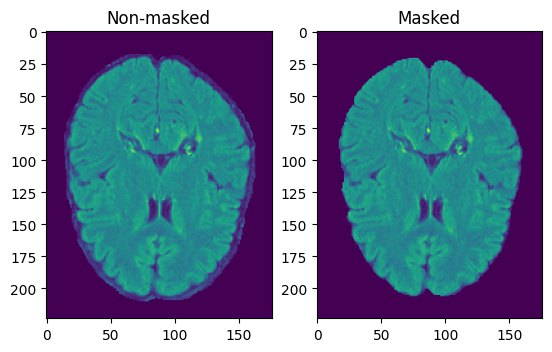

In [14]:
sample = dataset_descriptor.train_dataset[0]  # underwent random flipping
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample['MRI'][0, 32, :, :])
ax[1].imshow(sample['MRI'][0, 32, :, :] * sample['MASK'][0, 32, :, :])

ax[0].set_title("Non-masked")
ax[1].set_title("Masked")

## Read in environment setting, including data directory, model directory, and output directory

The information for data directory, model directory, and output directory are saved in `"./configs/environment_maisi_vae_train.json"`

In [15]:
args = argparse.Namespace()

environment_file = "./configs/environment_maisi_vae_train.json"
env_dict = json.load(open(environment_file, "r"))
for k, v in env_dict.items():
    setattr(args, k, v)
    print(f"{k}: {v}")

# model path
Path(args.model_dir).mkdir(parents=True, exist_ok=True)
trained_g_path = os.path.join(args.model_dir, "autoencoder.pt")
trained_d_path = os.path.join(args.model_dir, "discriminator.pt")
print(f"Trained model will be saved as {trained_g_path} and {trained_d_path}.")

# initialize tensorboard writer
Path(args.tfevent_path).mkdir(parents=True, exist_ok=True)
tensorboard_path = os.path.join(args.tfevent_path, "autoencoder")
Path(tensorboard_path).mkdir(parents=True, exist_ok=True)
# tensorboard_writer = SummaryWriter(tensorboard_path)
print(f"Tensorboard event will be saved as {tensorboard_path}.")

model_dir: ./models/
tfevent_path: ./outputs/tfevent
Trained model will be saved as ./models/autoencoder.pt and ./models/discriminator.pt.
Tensorboard event will be saved as ./outputs/tfevent/autoencoder.


## Read in configuration setting, including network definition, body region and anatomy to generate, etc.

The information for the training hyperparameters and data processing parameters, like learning rate and patch size, are stored in `"./configs/config_maisi_vae_train"`. Please refer to README.md for the details.

In [16]:
config_file = "./configs/config_maisi.json"
config_dict = json.load(open(config_file, "r"))
for k, v in config_dict.items():
    setattr(args, k, v)

# check the format of inference inputs
config_train_file = "./configs/config_maisi_vae_train.json"
config_train_dict = json.load(open(config_train_file, "r"))
for k, v in config_train_dict["data_option"].items():
    setattr(args, k, v)
    print(f"{k}: {v}")
for k, v in config_train_dict["autoencoder_train"].items():
    setattr(args, k, v)
    print(f"{k}: {v}")

print("Network definition and training hyperparameters have been loaded.")

random_aug: True
spacing_type: rand_zoom
spacing: None
select_channel: 0
batch_size: 1
patch_size: [64, 64, 64]
val_batch_size: 1
val_patch_size: None
val_sliding_window_patch_size: [96, 96, 64]
lr: 0.0001
perceptual_weight: 0.3
kl_weight: 1e-07
adv_weight: 0.1
recon_loss: l1
val_interval: 10
cache: 0.5
amp: True
n_epochs: 1
Network definition and training hyperparameters have been loaded.


## Set deterministic training for reproducibility

In [17]:
set_determinism(seed=0)

## Initialize networks

In [18]:
args.autoencoder_def["num_splits"] = 1
autoencoder = define_instance(args, "autoencoder_def").to(DEVICE)
discriminator_norm = "INSTANCE"
discriminator = PatchDiscriminator(
    spatial_dims=args.spatial_dims,
    num_layers_d=3,
    channels=32,
    in_channels=1,
    out_channels=1,
    norm=discriminator_norm,
).to(DEVICE)

## Load pre-trained autoencoder

In [19]:
state_dict = torch.load('models/autoencoder_epoch273.pt')
autoencoder.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
args.autoencoder_def

{'_target_': 'monai.apps.generation.maisi.networks.autoencoderkl_maisi.AutoencoderKlMaisi',
 'spatial_dims': '@spatial_dims',
 'in_channels': '@image_channels',
 'out_channels': '@image_channels',
 'latent_channels': '@latent_channels',
 'num_channels': [64, 128, 256],
 'num_res_blocks': [2, 2, 2],
 'norm_num_groups': 32,
 'norm_eps': 1e-06,
 'attention_levels': [False, False, False],
 'with_encoder_nonlocal_attn': False,
 'with_decoder_nonlocal_attn': False,
 'use_checkpointing': False,
 'use_convtranspose': False,
 'norm_float16': True,
 'num_splits': 1,
 'dim_split': 1}

## Training config

In [21]:
# config loss and loss weight
if args.recon_loss == "l2":
    intensity_loss = MSELoss()
    print("Use l2 loss")
else:
    intensity_loss = L1Loss(reduction="mean")
    print("Use l1 loss")
adv_loss = PatchAdversarialLoss(criterion="least_squares")

loss_perceptual = (
    PerceptualLoss(spatial_dims=3, network_type="squeeze", is_fake_3d=True, fake_3d_ratio=0.2).eval().to(DEVICE)
)

# config optimizer and lr scheduler
optimizer_g = torch.optim.Adam(params=autoencoder.parameters(), lr=args.lr, eps=1e-06 if args.amp else 1e-08)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=args.lr, eps=1e-06 if args.amp else 1e-08)


# please adjust the learning rate warmup rule based on your dataset and n_epochs
def warmup_rule(epoch):
    # learning rate warmup rule
    if epoch < 10:
        return 0.01
    elif epoch < 20:
        return 0.1
    else:
        return 1.0


scheduler_g = lr_scheduler.LambdaLR(optimizer_g, lr_lambda=warmup_rule)
scheduler_d = lr_scheduler.LambdaLR(optimizer_d, lr_lambda=warmup_rule)

# set AMP scaler
if args.amp:
    # test use mean reduction for everything
    scaler_g = GradScaler(DEVICE, init_scale=2.0**8, growth_factor=1.5)
    scaler_d = GradScaler(DEVICE, init_scale=2.0**8, growth_factor=1.5)

Use l1 loss


## Helper functions for training

In [22]:
# TODO: May need to adjust this based on the MAISI training protocol (e.g., they normalize to 99.5th percentile)
def build_batch(batch, device):
    for key, value in batch.items():
        if key in ['MRI', 'MASK']:
            batch[key] = value.to(device, non_blocking=True)

    # Apply transforms
    batch['MRI'] = CustomTransforms.denoise(batch['MRI'], batch['MASK'])  # skull-stripping (multiply MRI with MASK)
    batch['MRI'] = CustomTransforms.standardize(batch['MRI'], batch['MASK'])  # standardize to 0 mean, 1 SD

    return batch

## Training

In [ ]:
# Initialize variables
val_interval = args.val_interval
best_val_recon_epoch_loss = 10000000.0
total_step = 0
start_epoch = 0
max_epochs = args.n_epochs

# Setup validation inferer
val_inferer = (
    SlidingWindowInferer(
        roi_size=args.val_sliding_window_patch_size,
        sw_batch_size=1,
        progress=False,
        overlap=0.0,
        device=torch.device("cpu"),
        sw_device=DEVICE,
    )
    if args.val_sliding_window_patch_size
    else SimpleInferer()
)


def loss_weighted_sum(losses):
    return losses["recons_loss"] + args.kl_weight * losses["kl_loss"] + args.perceptual_weight * losses["p_loss"]


# Training and validation loops
for epoch in range(start_epoch, max_epochs):
    print("lr:", scheduler_g.get_lr())
    autoencoder.train()
    discriminator.train()
    train_epoch_losses = {"recons_loss": 0, "kl_loss": 0, "p_loss": 0}

    for batch in dataloader_train:

        batch = build_batch(batch, DEVICE)  # key step
        images = batch['MRI'].contiguous()

        optimizer_g.zero_grad(set_to_none=True)
        optimizer_d.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=args.amp):
            # Train Generator
            reconstruction, z_mu, z_sigma = autoencoder(images)
            losses = {
                "recons_loss": intensity_loss(reconstruction, images),
                "kl_loss": KL_loss(z_mu, z_sigma),
                "p_loss": loss_perceptual(reconstruction.float(), images.float()),
            }
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g = loss_weighted_sum(losses) + args.adv_weight * generator_loss

            if args.amp:
                scaler_g.scale(loss_g).backward()
                scaler_g.unscale_(optimizer_g)
                scaler_g.step(optimizer_g)
                scaler_g.update()
            else:
                loss_g.backward()
                optimizer_g.step()

            # Train Discriminator
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            loss_d = (loss_d_fake + loss_d_real) * 0.5

            if args.amp:
                scaler_d.scale(loss_d).backward()
                scaler_d.step(optimizer_d)
                scaler_d.update()
            else:
                loss_d.backward()
                optimizer_d.step()

        # Log training loss
        total_step += 1
        for loss_name, loss_value in losses.items():
            # tensorboard_writer.add_scalar(f"train_{loss_name}_iter", loss_value.item(), total_step)
            train_epoch_losses[loss_name] += loss_value.item()
        # tensorboard_writer.add_scalar("train_adv_loss_iter", generator_loss, total_step)
        # tensorboard_writer.add_scalar("train_fake_loss_iter", loss_d_fake, total_step)
        # tensorboard_writer.add_scalar("train_real_loss_iter", loss_d_real, total_step)

    scheduler_g.step()
    scheduler_d.step()
    for key in train_epoch_losses:
        train_epoch_losses[key] /= len(dataloader_train)
    print(f"Epoch {epoch} train_vae_loss {loss_weighted_sum(train_epoch_losses)}: {train_epoch_losses}.")
    # for loss_name, loss_value in train_epoch_losses.items():
        # tensorboard_writer.add_scalar(f"train_{loss_name}_epoch", loss_value, epoch)
    torch.save(autoencoder.state_dict(), trained_g_path)
    torch.save(discriminator.state_dict(), trained_d_path)
    print("Save trained autoencoder to", trained_g_path)
    print("Save trained discriminator to", trained_d_path)

    # Validation
    if epoch % val_interval == 0:
        autoencoder.eval()
        val_epoch_losses = {"recons_loss": 0, "kl_loss": 0, "p_loss": 0}
        val_loader_iter = iter(dataloader_val)
        for batch in dataloader_val:
            with torch.no_grad():
                with autocast("cuda", enabled=args.amp):
                    
                    batch = build_batch(batch, 'cpu')  # key step
                    images = batch["MRI"]

                    reconstruction, _, _ = dynamic_infer(val_inferer, autoencoder, images)
                    reconstruction = reconstruction.to(DEVICE)
                    val_epoch_losses["recons_loss"] += intensity_loss(reconstruction, images.to(DEVICE)).item()
                    val_epoch_losses["kl_loss"] += KL_loss(z_mu, z_sigma).item()
                    val_epoch_losses["p_loss"] += loss_perceptual(reconstruction, images.to(DEVICE)).item()

        for key in val_epoch_losses:
            val_epoch_losses[key] /= len(dataloader_val)

        val_loss_g = loss_weighted_sum(val_epoch_losses)
        print(f"Epoch {epoch} val_vae_loss {val_loss_g}: {val_epoch_losses}.")

        if val_loss_g < best_val_recon_epoch_loss:
            best_val_recon_epoch_loss = val_loss_g
            trained_g_path_epoch = f"{trained_g_path[:-3]}_epoch{epoch}.pt"
            torch.save(autoencoder.state_dict(), trained_g_path_epoch)
            print("Got best val vae loss.")
            print("Save trained autoencoder to", trained_g_path_epoch)

        # for loss_name, loss_value in val_epoch_losses.items():
        #     tensorboard_writer.add_scalar(loss_name, loss_value, epoch)

        # Monitor scale_factor
        # We'd like to tune kl_weights in order to make scale_factor close to 1.
        scale_factor_sample = 1.0 / z_mu.flatten().std()
        # tensorboard_writer.add_scalar("val_one_sample_scale_factor", scale_factor_sample, epoch)

        # Monitor reconstruction result
        center_loc_axis = find_label_center_loc(images[0, 0, ...])
        vis_image = get_xyz_plot(images[0, ...], center_loc_axis, mask_bool=False)
        vis_recon_image = get_xyz_plot(reconstruction[0, ...], center_loc_axis, mask_bool=False)

        # tensorboard_writer.add_image(
        #     "val_orig_img",
        #     vis_image.transpose([2, 0, 1]),
        #     epoch,
        # )
        # tensorboard_writer.add_image(
        #     "val_recon_img",
        #     vis_recon_image.transpose([2, 0, 1]),
        #     epoch,
        # )

        show_image(vis_image, title="val image")
        show_image(vis_recon_image, title="val recon result")

lr: [1.0000000000000002e-06]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 